## Callin Switzer
10 Dec 2018
### Modified TLD script for running simulation

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
import sys
import pandas as pd
print(sys.version)
now = datetime.now()
print("last run on " + str(now))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
last run on 2019-01-01 20:46:58.157952


In [44]:
# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData'

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


In [13]:
def FlyTheBug(state,t):
    # unpack the state vector
    # displacement,x and velocity xd  etc...
    # Jorge's order .  x,y,theta,phi,xd,yd,thetad,phid
    x,xd,y,yd,theta,thetad,phi,phid, F, alpha, tau0 = state
    
    #Reynolds number calculation:
    Re_head = rhoA*(np.sqrt((xd**2)+(yd**2)))*(2*bhead)/muA; #dimensionless number
    Re_butt = rhoA*(np.sqrt((xd**2)+(yd**2)))*(2*bbutt)/muA; #dimensionless number

    #Coefficient of drag
    Cd_head = 24/np.abs(Re_head) + 6/(1 + np.sqrt(np.abs(Re_head))) + 0.4
    Cd_butt = 24/np.abs(Re_butt) + 6/(1 + np.sqrt(np.abs(Re_butt))) + 0.4
    
    h1 = m1 + m2
    h2 = (-1)*L1*m1*np.sin(theta)
    h3 = (-1)*L2*m2*np.sin(phi)
    h4 = L1*m1*np.cos(theta)
    h5 = L2*m2*np.cos(phi)
    h6 = (-1)*F*np.cos(alpha+theta)+(1/2)*Cd_butt*rhoA*S_butt* \
            np.abs(xd)*xd+(1/2)*Cd_head*rhoA*S_head*np.abs(xd)* \
            xd+(-1)*L1*m1*np.cos(theta)*thetad**2+(-1)*L2*m2*np.cos(phi)*phid**2
    h7 = g*(m1+m2)+(1/2)*Cd_butt*rhoA*S_butt*np.abs(yd)*yd+(1/2)* \
            Cd_head*rhoA*S_head*np.abs(yd)*yd+(-1)*L1*m1*thetad**2* \
            np.sin(theta)+(-1)*F*np.sin(alpha+theta)+(-1)*L2*m2*phid**2*np.sin(phi)
    h8 = (-1)*tau0+g*L1*m1*np.cos(theta)+(-1)*K*((-1)*betaR+(-1)*np.pi+(-1)* \
            theta+phi)+(-1)*c*((-1)*thetad+phid)+(-1)*F*L3*np.sin(alpha)
    h9 = tau0+g*L2*m2*np.cos(phi)+K*((-1)*betaR+(-1)*np.pi+(-1)*theta+phi)+c*((-1)*thetad+phid)
    h10 = I1+L1**2*m1
    h11 = I2+L2**2*m2

    xdd = (-1)*(h10*h11*h1**2+(-1)*h11*h1*h2**2+(-1)*h10*h1*h3**2+ \
                (-1)*h11*h1*h4**2+h3**2*h4**2+(-2)*h2* 
        h3*h4*h5+(-1)*h10*h1*h5**2+h2**2*h5**2)**(-1)*( 
        h10*h11*h1*h6+(-1)*h11*h4**2*h6+(-1)*h10*h5**2* 
        h6+h11*h2*h4*h7+h10*h3*h5*h7+(-1)*h11*h1*h2* 
        h8+(-1)*h3*h4*h5*h8+h2*h5**2*h8+(-1)*h10*h1* 
        h3*h9+h3*h4**2*h9+(-1)*h2*h4*h5*h9)
  
    ydd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*((-1)*h11*
        h2*h4*h6+(-1)*h10*h3*h5*h6+(-1)*h10*h11*h1*
        h7+h11*h2**2*h7+h10*h3**2*h7+h11*h1*h4*h8+(-1)*
        h3**2*h4*h8+h2*h3*h5*h8+h2*h3*h4*h9+h10*h1*
        h5*h9+(-1)*h2**2*h5*h9)
    
    thetadd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*(h11*h1*
        h2*h6+h3*h4*h5*h6+(-1)*h2*h5**2*h6+h11*h1*
        h4*h7+(-1)*h3**2*h4*h7+h2*h3*h5*h7+(-1)*h11*
        h1**2*h8+h1*h3**2*h8+h1*h5**2*h8+(-1)*h1*h2*
        h3*h9+(-1)*h1*h4*h5*h9);

    phidd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*(h10*h1*
        h3*h6+(-1)*h3*h4**2*h6+h2*h4*h5*h6+h2*h3*h4*
        h7+h10*h1*h5*h7+(-1)*h2**2*h5*h7+(-1)*h1*h2*
        h3*h8+(-1)*h1*h4*h5*h8+(-1)*h10*h1**2*h9+h1*
        h2**2*h9+h1*h4**2*h9)
    
    return(np.array([xd, xdd,yd,ydd,thetad,thetadd,phid,phidd, F, alpha, tau0]))

In [14]:
# Global variables

# Bunches of parameters ...  these don't vary from run to run 
# masses and moment of inertias in terms of insect density and eccentricity
# of the head/thorax & gaster

bhead = 0.507
ahead = 0.908
bbutt  = 0.1295
abutt  = 1.174

# cgs  density of insect 
rho = 1 

# cgs density of air
rhoA = 0.00118

# cgs viscosity
muA = 0.000186 

# Length from the thorax-abdomen joint to the center of the 
# head-thorax mass in cm
L1 = 0.908 

# Length from the thorax-abdomen joint to the center of the 
# abdomen mass in cm
L2 = 1.747  

# Length from the thorax-abdomen joint to the aerodynamic force 
# vector in cm
L3 = 0.75 

# m1 is the mass of the head-thorax
m1 = rho*(4/3)*np.pi*(bhead**2)*ahead

# m2 is the mass of the abdomen 
# (petiole + gaster)
m2 = rho*(4/3)*np.pi*(bbutt**2)*abutt

echead = ahead/bhead; #Eccentricity of head-thorax (unitless)
ecbutt = abutt/bbutt; #Eccentricity of gaster (unitless)
I1 = (1/5)*m1*(ahead**2)*(1 + echead**2); #Moment of inertia of the 
    #head-thorax
I2 = (1/5)*m2*(abutt**2)*(1 + ecbutt**2); #Moment of inertia of the gaster

#This is the surface area of the object experiencing drag.
S_head = np.pi*bhead**2

#This is the surface area of the object experiencing drag.
S_butt = np.pi*bbutt**2 

# K is the torsional spring constant of the thorax-petiole joint
# in (cm^2)*g/(rad*(s^2))
K = 29.3 

# c is the torsional damping constant of the thorax-petiole joint
# in (cm^2)*g/s
c =  14075.8   
g =  980.0   #g is the acceleration due to gravity in cm/(s^2)

# This is the resting configuration of our 
# torsional spring(s) = Initial abdomen angle - initial head angle - pi
betaR =  0.0 
    

In [15]:
# Predict steps with nnet (without feedback)

# Generate path to follow
# 2 Hz sine wave, points 0.02 sec apart
tsteps = np.linspace(0, 0.5, num = 26)
sig = 10 * np.sin(2*np.pi* 2*tsteps)

tsteps

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 ])

In [16]:
y_error = np.hstack([np.nan, np.diff(sig)])

x_0 = np.repeat(0, len(tsteps))
x_f = x_0.copy()
y_0 = x_0.copy()
y_error = np.hstack([np.nan, np.diff(sig)])
theta_0 = np.repeat(0.785398, len(tsteps))
phi_0 = np.repeat(3.926991, len(tsteps))
x_dot_0 = np.repeat(0.0001, len(tsteps))
y_dot_0 = np.repeat(0.0001, len(tsteps))
phi_dot_0 = np.repeat(0.0001, len(tsteps))
theta_dot_0 = np.repeat(0.0001, len(tsteps))
Fx = np.repeat(0, len(tsteps))
Fy = np.repeat(0, len(tsteps))
tau = np.repeat(0, len(tsteps))


predDF = pd.DataFrame(np.transpose(np.array([tsteps, 
                                             sig, 
                                             x_0,
                                             x_f,
                                             y_0,
                                             y_error,
                                             theta_0,
                                             theta_0,
                                             phi_0, 
                                             phi_0, 
                                             x_dot_0, 
                                             y_dot_0, 
                                             phi_dot_0, 
                                             theta_dot_0, 
                                             Fx, 
                                             Fy, 
                                             tau
                                            ])), 
                     columns=["tsteps", "signal", "x_0", "x_99", "y_0", "y_99", 
                             "theta_0", "theta_99", "phi_0", "phi_99", 
                             "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0", 
                             "Fx", "Fy", "tau_pred"])

predDF.head()

,tsteps,signal,x_0,x_99,y_0,y_99,theta_0,theta_99,phi_0,phi_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,Fx,Fy,tau_pred
0,0.00,0.000000,0.0,0.0,0.0,NaN,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0
1,0.02,2.486899,0.0,0.0,0.0,2.486899,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0
2,0.04,4.817537,0.0,0.0,0.0,2.330638,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0
3,0.06,6.845471,0.0,0.0,0.0,2.027934,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0
4,0.08,8.443279,0.0,0.0,0.0,1.597808,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0


In [21]:
# convert to F, alpha, tau
predDF["F_pred"] = np.sqrt(predDF["Fx"]**2 + predDF["Fy"]**2)

# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)

predDF["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(predDF["Fx"], predDF["Fy"])]

def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

predDF["alpha_pred"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(predDF["Fx"], predDF["Fy"], predDF["quadrant"])]

predDF.head()

C:\Users\calli\Anaconda3\envs\numSolve\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


,tsteps,signal,x_0,x_99,y_0,y_99,theta_0,theta_99,phi_0,phi_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,Fx,Fy,tau_pred,F_pred,quadrant,alpha_pred
0,0.00,0.000000,0.0,0.0,0.0,NaN,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,1,NaN
1,0.02,2.486899,0.0,0.0,0.0,2.486899,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,1,NaN
2,0.04,4.817537,0.0,0.0,0.0,2.330638,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,1,NaN
3,0.06,6.845471,0.0,0.0,0.0,2.027934,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,1,NaN
4,0.08,8.443279,0.0,0.0,0.0,1.597808,0.785398,0.785398,3.926991,3.926991,0.0001,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,1,NaN


In [23]:
state0 = np.array(predDF.loc[ii, ["x_0", "x_dot_0", "y_0", "y_dot_0", "theta_0", "theta_dot_0", "F_pred", "alpha_pred"]])
state0

array([0.00000e+00, 1.00000e-04, 0.00000e+00, 1.00000e-04, 7.85398e-01,
       1.00000e-04, 0.00000e+00,         nan])

In [45]:
predDF = pd.read_csv(os.path.join(dataOutput, "pathPrediction.csv"))

___

In [70]:
#This cell just checks to be sure we can run this puppy and graph results.
#         x,    xd,    y,   yd,    theta,  thetad,       phi,     phid,         F,          alpha,       tau0
rowNum = 4
predDF = pd.read_csv(os.path.join(dataOutput, "pathPrediction.csv"))

predDF.loc[rowNum, ["x_0", "x_dot_0", "y_0", "y_dot_0", "theta_0", "theta_dot_0", "phi_0", "phi_dot_0"]]

x_0            -29.498495
x_dot_0       -675.001114
y_0             42.071666
y_dot_0        671.938846
theta_0          1.674637
theta_dot_0     17.558187
phi_0            4.849789
phi_dot_0       17.897622
Name: 4, dtype: float64

In [71]:
state0 = np.array(predDF.loc[rowNum, ["x_0", "x_dot_0", "y_0", "y_dot_0", "theta_0", "theta_dot_0", "phi_0", "phi_dot_0", "F_pred", "alpha_pred", "tau_pred"]])

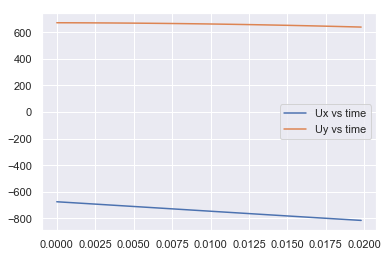

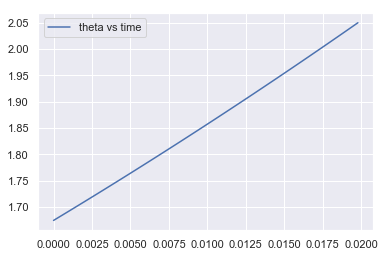

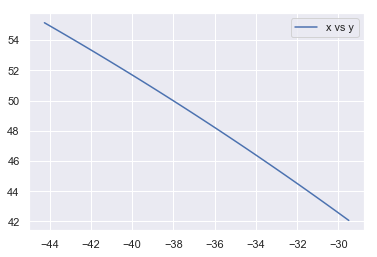

In [72]:
#         x,    xd,    y,   yd,    theta,  thetad,       phi,     phid,         F,          alpha,       tau0
#state0 = [0.0, 0.0001, 0.0, 0.0001, 0.785398, 0.0001,    3.926991, 0.0001,     8513.070028, 1.339053, -3895.695801]  #initial conditions [x0 , v0  etc0 ]
ti = 0.0  # initial time
tf = 0.02  # final time
nstep = 100
step = (tf-ti)/nstep  # step
t = np.arange(ti, tf, step)
state = odeint(FlyTheBug, state0, t)
x = np.array(state[:,[0]])
xd = np.array(state[:,[1]])
y = np.array(state[:,[2]])
yd = np.array(state[:,[3]])
theta = np.array(state[:,[4]])
thetad = np.array(state[:,[5]])
phi = np.array(state[:,[6]])
phid = np.array(state[:,[7]])
#  And let's just plot it all
sns.set()
plt.figure()
plt.plot(t,xd, label = 'Ux vs time')
plt.plot(t,yd, label = 'Uy vs time')
plt.legend()
plt.figure()
plt.plot(t,theta, label = 'theta vs time')
plt.legend()
plt.figure()
plt.plot(x,y, label = 'x vs y')
plt.legend()

In [73]:
# get final values
[x[-1, 0], xd[-1, 0], y[-1, 0], yd[-1, 0], theta[-1, 0], thetad[-1, 0], phi[-1, 0], phid[-1, 0]] # this checks out

[-44.25776313553574,
 -815.4245488985321,
 55.146471684974486,
 639.3368156527224,
 2.049779294815162,
 20.336940630025254,
 5.23154914477651,
 20.674704195394455]

___

In [25]:
# specify ranges
# x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0
ranges = np.array([[0, 0], [-1500, 1500], [0, 0], [-1500, 1500],   
                   [0, 2*np.pi], [-25, 25], [0, 2*np.pi], [-25, 25], 
                  [0, 44300], [0, 2*np.pi], [-100000, 100000]])

tic = time.time()
t = np.linspace(0, 0.02, num = 100, endpoint = False) # time cut into 100 timesteps
nrun = 100  #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nstep, nrun])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]))

# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(FlyTheBug, state0[i, :], t)
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
print('elapsed time = ',time.time()-tic)

elapsed time =  2.109321355819702


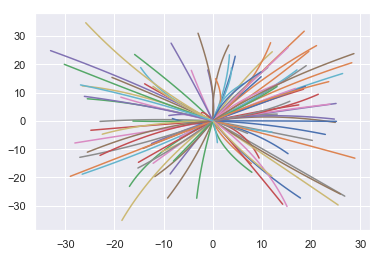

In [26]:
plt.figure()
for i in range(0,nrun):
    plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')